<a href="https://colab.research.google.com/github/ShivamKr-T/Phishing/blob/main/phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
import pandas as pd

file_paths = [
    '/content/phishing_email.csv',
    '/content/Nigerian_Fraud.csv',
    '/content/SpamAssasin.csv',
    '/content/Enron.csv'
]

def clean_csv(file_path):
    df = pd.read_csv(file_path)

    df.columns = df.columns.str.strip()

    df.drop_duplicates(inplace=True)

    df.dropna(how='all', inplace=True)
    df.fillna('', inplace=True)

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip().str.lower()

    cleaned_path = file_path.replace('.csv', '_cleaned.csv')
    df.to_csv(cleaned_path, index=False)
    print(f"✅ Cleaned file saved to: {cleaned_path}")

for path in file_paths:
    clean_csv(path)


✅ Cleaned file saved to: /content/phishing_email_cleaned.csv
✅ Cleaned file saved to: /content/Nigerian_Fraud_cleaned.csv
✅ Cleaned file saved to: /content/SpamAssasin_cleaned.csv
✅ Cleaned file saved to: /content/Enron_cleaned.csv


In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
phishing = pd.read_csv('/content/phishing_email_cleaned.csv')
nigerian = pd.read_csv('/content/Nigerian_Fraud_cleaned.csv')
spamassassin = pd.read_csv('/content/SpamAssasin_cleaned.csv')
enron = pd.read_csv('/content/Enron_cleaned.csv')

phishing['label'] = 1
nigerian['label'] = 1
spamassassin['label'] = 0
enron['label'] = 0

df = pd.concat([phishing, nigerian, spamassassin, enron], ignore_index=True)
print(f"Combined Dataset Shape: {df.shape}")


Combined Dataset Shape: (120986, 8)


In [ ]:
email_col = next((col for col in df.columns if 'body' in col.lower() or 'content' in col.lower()), None)

if email_col:
    df['num_urls'] = df[email_col].apply(lambda x: len(re.findall(r'http[s]?://', str(x))))
else:
    print("⚠️ Email body column not found. Please check column names.")


In [ ]:
print("🔍 Columns in DataFrame:", df.columns.tolist())


🔍 Columns in DataFrame: ['text_combined', 'label', 'sender', 'receiver', 'date', 'subject', 'body', 'urls', 'num_urls']


In [ ]:
def extract_features(df):
    df['body'] = df['body'].astype(str)

    df['num_urls'] = df['body'].apply(lambda x: len(re.findall(r'http[s]?://', x)))

    df['has_ip_url'] = df['body'].apply(lambda x: int(bool(re.search(r'http[s]?://\d+\.\d+\.\d+\.\d+', x))))

    df['url_length'] = df['body'].apply(lambda x: max([len(url) for url in re.findall(r'http[s]?://\S+', x)] + [0]))

    phishing_keywords = ['verify', 'account', 'urgent', 'click', 'login', 'password', 'update']
    df['keyword_count'] = df['body'].apply(lambda x: sum([x.lower().count(kw) for kw in phishing_keywords]))

    df['num_exclamations'] = df['body'].apply(lambda x: x.count('!'))

    tfidf = TfidfVectorizer(max_features=300)
    tfidf_matrix = tfidf.fit_transform(df['body'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return df

df_features = extract_features(df)
print(df_features.head())


                                       text_combined  label sender receiver  \
0  hpl nom may 25 2001 see attached file hplno 52...      1    NaN      NaN   
1  nom actual vols 24 th forwarded sabrae zajac h...      1    NaN      NaN   
2  enron actuals march 30 april 1 201 estimated a...      1    NaN      NaN   
3  hpl nom may 30 2001 see attached file hplno 53...      1    NaN      NaN   
4  hpl nom june 1 2001 see attached file hplno 60...      1    NaN      NaN   

  date subject body  urls  num_urls  has_ip_url  ...  within  without  work  \
0  NaN     NaN  nan   NaN         0           0  ...     0.0      0.0   0.0   
1  NaN     NaN  nan   NaN         0           0  ...     0.0      0.0   0.0   
2  NaN     NaN  nan   NaN         0           0  ...     0.0      0.0   0.0   
3  NaN     NaN  nan   NaN         0           0  ...     0.0      0.0   0.0   
4  NaN     NaN  nan   NaN         0           0  ...     0.0      0.0   0.0   

   world  would  www  year  years  you  your  
0  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

non_numeric_cols = ['sender', 'receiver', 'subject', 'body', 'date', 'text_combined', 'urls']

X = df_features.drop(non_numeric_cols + ['label'], axis=1)
y = df_features['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling completed successfully!")


✅ Scaling completed successfully!


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)  # Random Forest handles unscaled data well
y_pred_rf = rf_clf.predict(X_test)

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"📊 {model_name} Performance:")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print(f"ROC AUC Score : {roc_auc:.4f}\n")

# Evaluate Both Models
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


📊 Logistic Regression Performance:
Accuracy      : 0.9938
Precision     : 0.9945
Recall        : 0.9967
F1 Score      : 0.9956
ROC AUC Score : 0.9917

📊 Random Forest Performance:
Accuracy      : 0.9935
Precision     : 0.9950
Recall        : 0.9957
F1 Score      : 0.9954
ROC AUC Score : 0.9919



In [ ]:
from xgboost import XGBClassifier

# XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Performance:
Accuracy      : 0.9961
Precision     : 0.9967
Recall        : 0.9978
F1 Score      : 0.9973
ROC AUC Score : 0.9949



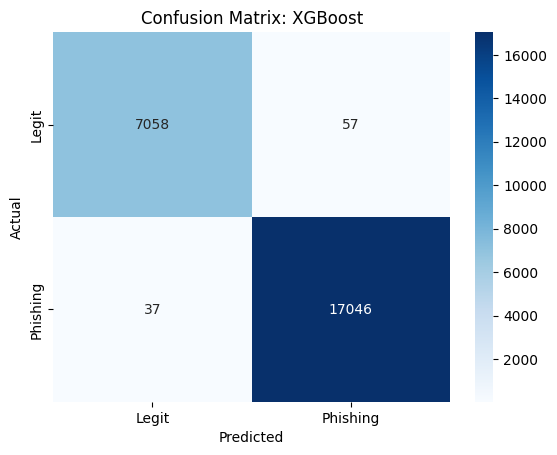

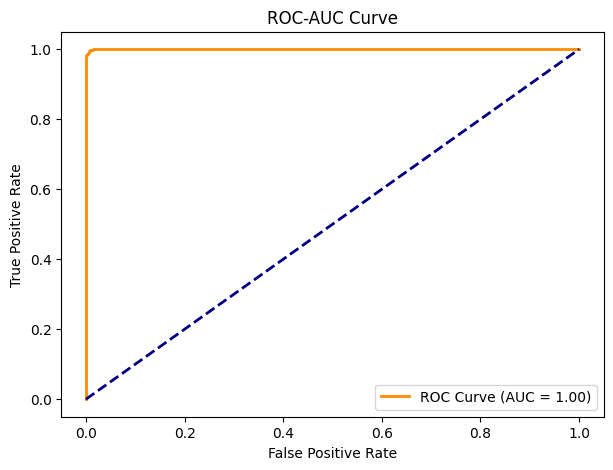

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


plot_conf_matrix(y_test, y_pred_xgb, "XGBoost")

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=  57.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:38:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=  48.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.6; total time=  49.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  37.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  34.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=400, subsample=0.8; total time=  35.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=  31.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=  28.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.8; total time=  34.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  31.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  28.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  29.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  33.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  31.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  32.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  21.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  20.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  23.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  30.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  29.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  28.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  26.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  24.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:49:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  24.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=  47.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=  46.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=400, subsample=0.8; total time=  45.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=  34.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=  35.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=1.0; total time=  35.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=  20.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=  18.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=10, n_estimators=100, subsample=1.0; total time=  19.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  25.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:55:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  21.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  21.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:56:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=  34.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:57:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=  32.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=10, n_estimators=200, subsample=1.0; total time=  31.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  28.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  25.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  25.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  26.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  22.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  22.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=  35.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:01:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=  33.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:01:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=400, subsample=1.0; total time=  34.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=  15.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=  13.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:03:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  26.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  26.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  27.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:04:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=  40.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=  42.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:05:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=300, subsample=1.0; total time=  44.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  33.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  29.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:07:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=400, subsample=0.6; total time=  30.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:08:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
📊 Tuned XGBoost Performance:
Accuracy      : 0.9960
Precision     : 0.9965
Recall        : 0.9978
F1 Score      : 0.9971
ROC AUC Score : 0.9947



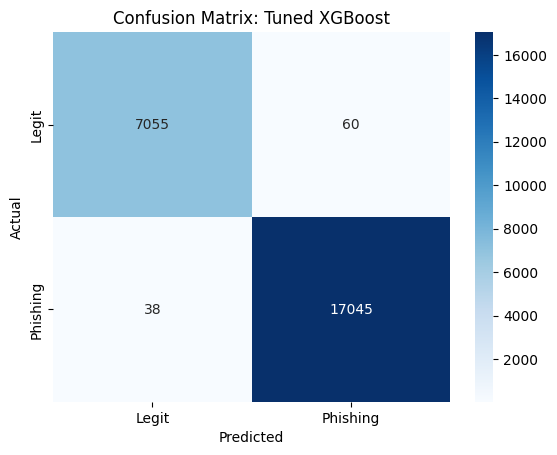

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=20, cv=3, scoring='f1', random_state=42, verbose=2)
random_search.fit(X_train, y_train)

print("🔍 Best Hyperparameters:", random_search.best_params_)

best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

evaluate_model(y_test, y_pred_best, "Tuned XGBoost")
plot_conf_matrix(y_test, y_pred_best, "Tuned XGBoost")


In [ ]:
import joblib

joblib.dump(best_xgb, 'phishing_email_detector.pkl')
print("💾 Model saved as phishing_email_detector.pkl")


💾 Model saved as phishing_email_detector.pkl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to Google Drive
!cp phishing_email_detector.pkl /content/drive/MyDrive/


Mounted at /content/drive
